In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv


In [2]:
import os
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import naive_bayes
from sklearn.metrics import confusion_matrix , roc_auc_score , classification_report,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
sentim_data=pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
sentim_data.head(10)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [4]:
sentim_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


# Cleaning the data

In [5]:
sentim_data.dropna(inplace=True)

sentim_data.info()

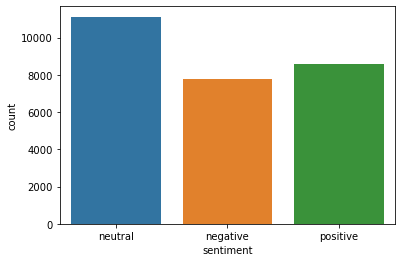

In [6]:
sns.countplot(x='sentiment', data=sentim_data)

In [7]:
sentim_data.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [8]:
vs=sentim_data['sentiment'].value_counts()
vs

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

False    16363
True     11117
Name: sentiment, dtype: int64

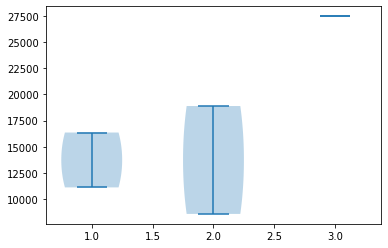

In [9]:
senti_nuteral=(sentim_data['sentiment']=='neutral').value_counts()
senti_pos=(sentim_data['sentiment']=='positive').value_counts()

senti_neg=(sentim_data['sentiment']=='negetive').value_counts()


data=list([senti_nuteral,senti_pos,senti_neg])
plt.violinplot(data)
senti_nuteral

In [10]:
sentim_data['no._textword']=sentim_data['text'].apply(lambda x:len(str(x).split()))
sentim_data['no._sel_text']=sentim_data['selected_text'].apply(lambda x:len(str(x).split()))

In [11]:
sentim_data.head()

,textID,text,selected_text,sentiment,no._textword,no._sel_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3


In [12]:
sentim_data['word_diff']=sentim_data['no._textword']-sentim_data['no._sel_text']

In [13]:
sentim_data.head()

,textID,text,selected_text,sentiment,no._textword,no._sel_text,word_diff
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,8
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,11


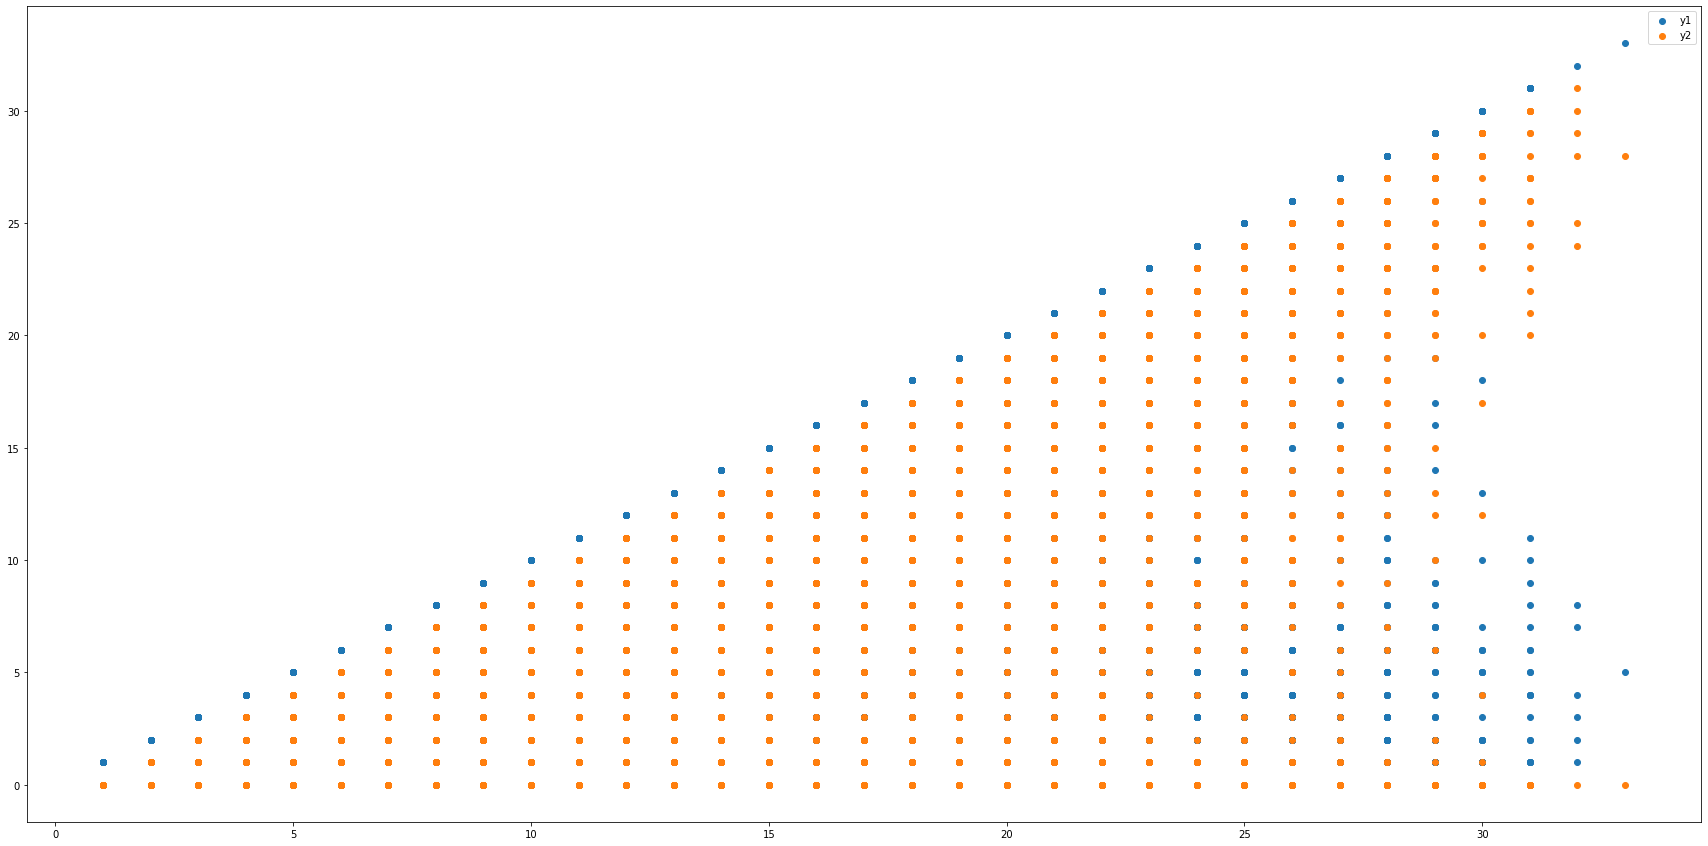

In [14]:
y1=sentim_data['no._textword']
y2=sentim_data['no._sel_text']
x=sentim_data['word_diff']
fig=plt.figure(figsize=(30,15))
plt.scatter(y1,y2)
plt.scatter(y1,x)
plt.legend(['y1','y2',x],loc='best')
plt.show()

In [15]:
temp = sentim_data.groupby('sentiment').count()['text']
temp

sentiment
negative     7781
neutral     11117
positive     8582
Name: text, dtype: int64

([<matplotlib.patches.Wedge at 0x7fa73859a510>,
 [Text(0.04186635016102199, 1.0992029879527234, 'neutral'),
  Text(-0.9602307943167208, -0.7196921714496274, 'positive'),
  Text(0.8902881227129237, -0.646054996541547, 'negative')],
 [Text(0.022836190996921083, 0.5995652661560309, '40.5%'),
  Text(-0.5601346300180869, -0.419820433345616, '31.2%'),
  Text(0.48561170329795833, -0.3523936344772074, '28.3%')])

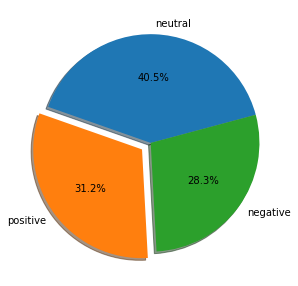

In [16]:
labels=['neutral','positive','negative']
size=[temp.neutral,temp.positive,temp.negative]
fig=plt.figure(figsize=(10,5))
my_explode = (0, 0.1, 0)
ax1=plt.subplot()
ax1.pie(size,labels=labels,autopct='%1.1f%%',shadow=True,startangle=15,explode=my_explode)

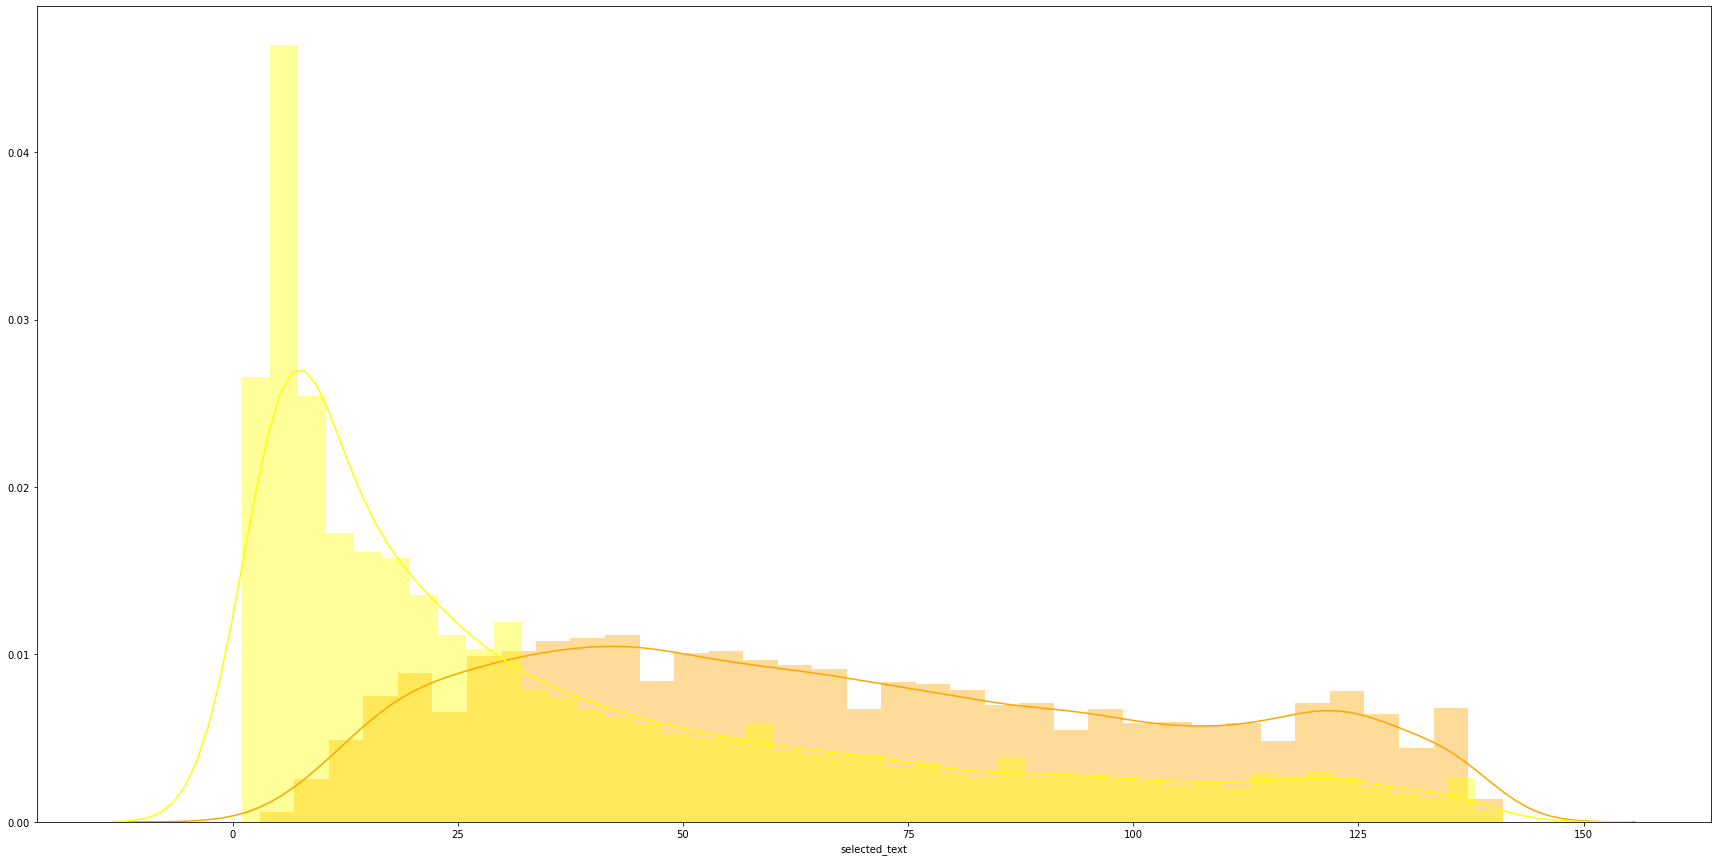

In [17]:
len_tweet = sentim_data['text'].apply(lambda x:len(str(x)))
len_selected = sentim_data['selected_text'].apply(lambda x:len(str(x)))
len_sentiment=sentim_data['sentiment'].apply(lambda x:len(str(x)))
fig=plt.figure(figsize=(30,15))
sns.distplot(len_tweet,norm_hist=True,color='orange')
sns.distplot(len_selected,norm_hist=True,color='yellow')


In [18]:
pcal=pd.get_dummies(sentim_data['sentiment'])
pcal

,negative,neutral,positive
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
27476,1,0,0
27477,1,0,0
27478,0,0,1
27479,0,0,1


In [19]:
sentim_data=pd.concat([sentim_data,pcal],axis=1)

In [20]:
sentim_data.head()

,textID,text,selected_text,sentiment,no._textword,no._sel_text,word_diff,negative,neutral,positive
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,0,0,1,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,8,1,0,0
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,3,1,0,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3,2,1,0,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,11,1,0,0


In [21]:
def cleanTxt(text):
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    return text

sentim_data['selected_text']=sentim_data['selected_text'].apply(cleanTxt)
sentim_data
     

,textID,text,selected_text,sentiment,no._textword,no._sel_text,word_diff,negative,neutral,positive
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,0,0,1,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,8,1,0,0
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,3,1,0,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3,2,1,0,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,11,1,0,0
...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16,2,14,1,0,0
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23,3,20,1,0,0
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22,6,16,0,0,1
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6,6,0,0,0,1


# Apply the subjectivity and polarity of the sentiment of selected_text

# Polarity

It simply means emotions expressed in a sentence.

Emotions are closely related to sentiments. The strength of a sentiment or opinion is typically linked to the intensity of certain emotions, e.g., joy and anger.

Opinions in sentiment analysis are mostly evaluations(although not always).

According to consumer behavior research, evaluations can be broadly categorized into two types:
1. Rational evaluations
2. Emotional evaluations.

Rational evaluation: Such evaluations are from rational reasoning, tangible

beliefs, and utilitarian attitudes. For example, the following sentences

Express rational evaluations: “The voice of this phone is clear,” “This car is worth the price,” and “I am happy with this car.”

Emotional evaluation: Such evaluations are from non-tangible and emotional responses to entities which go deep into people’s state of mind.

For example, the following sentences express emotional evaluations: “I love iPhone,” “I am so angry with their service people” and “This is the best car ever built.”

To make use of these two types of evaluations in practice, we can design 5 sentiment ratings, emotional negative (-2), rational negative (-1), neutral (0), rational positive (+1), and emotional positive (+2). In practice, neutral often means no opinion or sentiment expressed.


# subjectivty

Subjectivity

Subjective sentence expresses some personal feelings, views, or beliefs.

An example

subjective sentence is “I like iPhone.” Subjective expressions come in many forms, e.g., opinions, allegations, desires, beliefs, suspicions, and speculations.

A subjective sentence may not express any sentiment.
For example, “I think that he went home” and “I want a camera that can take good photos” are a subjective sentences, but does not express any sentiment


In [22]:
def getsubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getpolarity(text):
    return TextBlob(text).sentiment.polarity

In [23]:
sentim_data['Subjectivity']=sentim_data['selected_text'].apply(getsubjectivity)
sentim_data['polarity']=sentim_data['selected_text'].apply(getpolarity)

In [24]:
sentim_data.head(15)

,textID,text,selected_text,sentiment,no._textword,no._sel_text,word_diff,negative,neutral,positive,Subjectivity,polarity
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,0,0,1,0,0.00,0.00
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,8,1,0,0,1.00,-0.50
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,3,1,0,0,0.00,0.00
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3,2,1,0,0,0.00,0.00
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,11,1,0,0,0.00,0.00
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,12,12,0,0,1,0,0.30,1.00
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,14,1,13,0,0,1,0.20,0.30
7,50e14c0bb8,Soooo high,Soooo high,neutral,2,2,0,0,1,0,0.54,0.16
8,e050245fbd,Both of you,Both of you,neutral,3,3,0,0,1,0,0.00,0.00
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,10,5,5,0,0,1,1.00,0.10


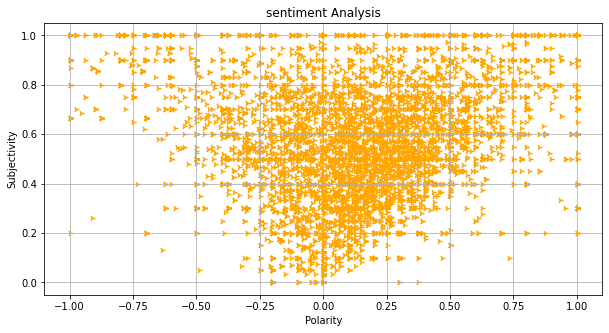

In [25]:
plt.figure(figsize=(10,5))
# for i in range(0,sentim_data.shape[0]):
plt.scatter(sentim_data['polarity'],sentim_data['Subjectivity'],marker='4',color='orange')
    
plt.title('sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid()
plt.show()
# here you see the majority of the sentiment is greater than 0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7384f92d0>,
      dtype=object)

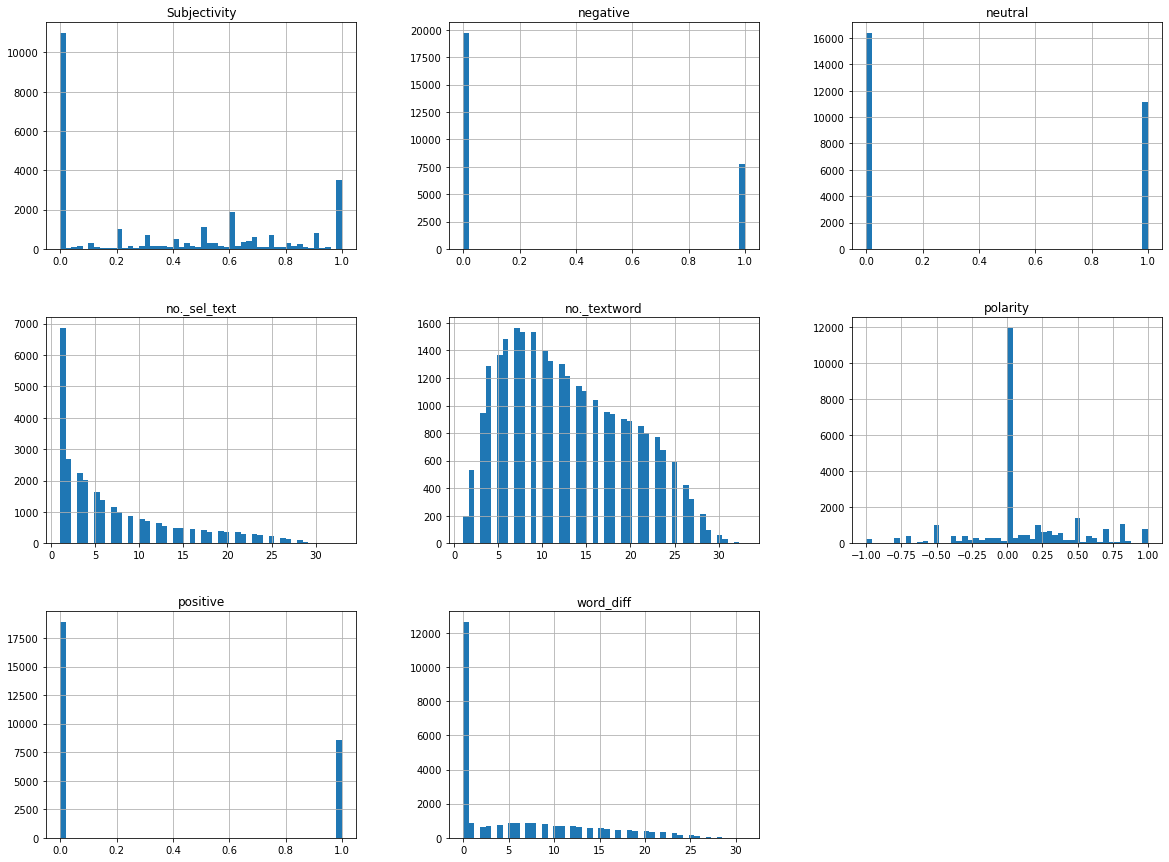

In [26]:
sentim_data.hist(bins=50 , figsize=(20,15))


In [27]:
corr_matrix=sentim_data.corr()

In [28]:
corr_matrix['polarity'].sort_values(ascending=False)

polarity        1.000000
positive        0.519197
Subjectivity    0.193668
no._textword    0.028774
word_diff       0.020242
no._sel_text    0.007626
neutral        -0.052245
negative       -0.477151
Name: polarity, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa73a550190>,
      dtype=object)

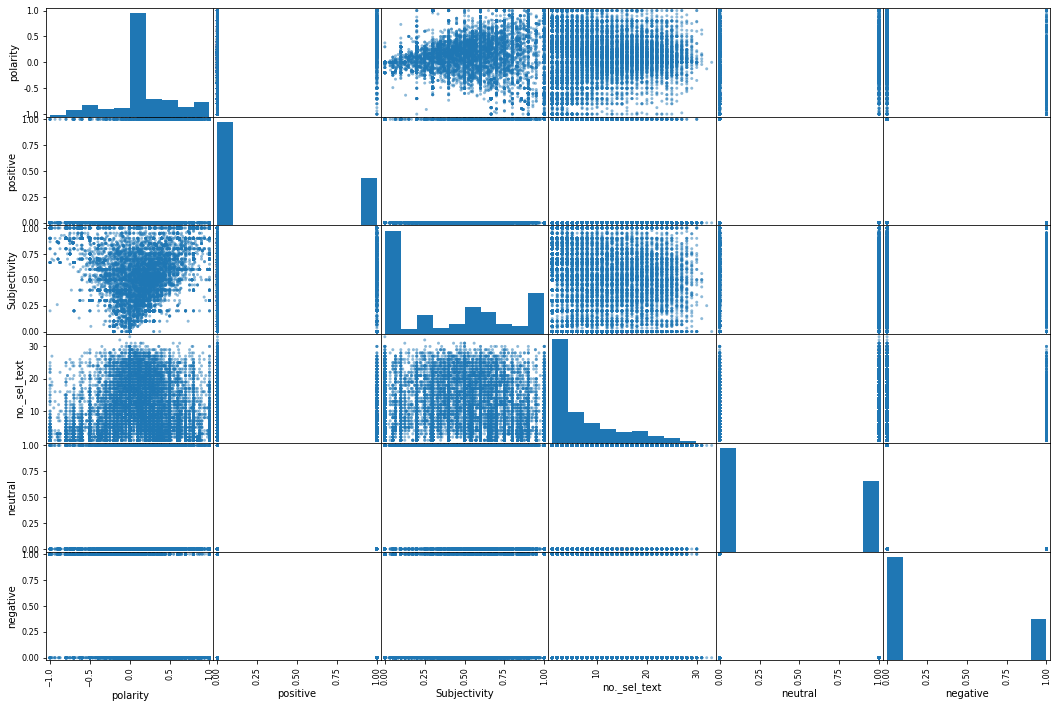

In [29]:
from pandas.plotting import scatter_matrix
attributes =["polarity" , "positive" , "Subjectivity" , "no._sel_text","neutral","negative"]
scatter_matrix(sentim_data[attributes], figsize=(18,12))

In [30]:
sample_data=[['Good case for the money !','positive'],
            ['Do not waste your money.','negetive'],
            ['Good product. Really good.Love it!','positive']]
small_sample=pd.DataFrame(sample_data,columns=['selected_text','sentiment'])

In [31]:
count_vec=CountVectorizer(binary=False, stop_words='english', ngram_range=(1,1),max_features=50000)
count_vec.fit(small_sample.selected_text)
small_tranformed=count_vec.transform(small_sample.selected_text)

In [32]:
small_sample

,selected_text,sentiment
0,Good case for the money !,positive
1,Do not waste your money.,negetive
2,Good product. Really good.Love it!,positive


In [33]:
from pandas import DataFrame
print(DataFrame(small_tranformed.A,columns=count_vec.get_feature_names()).to_string())

   case  good  love  money  product  really  waste
0     1     1     0      1        0       0      0
1     0     0     0      1        0       0      1
2     0     2     1      0        1       1      0


In [34]:
type(small_tranformed)

scipy.sparse.csr.csr_matrix

In [35]:
small_tranformed.A

array([[1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1],
       [0, 2, 1, 0, 1, 1, 0]])

In [36]:
tfidf=TfidfTransformer(use_idf=True)
tfidf.fit(small_tranformed)
small_tfidf=tfidf.transform(small_tranformed)

In [37]:
print(DataFrame(small_tfidf.A,columns=count_vec.get_feature_names()).to_string())

       case      good      love     money   product    really     waste
0  0.680919  0.517856  0.000000  0.517856  0.000000  0.000000  0.000000
1  0.000000  0.000000  0.000000  0.605349  0.000000  0.000000  0.795961
2  0.000000  0.659857  0.433816  0.000000  0.433816  0.433816  0.000000


In [38]:
lr=LogisticRegression(penalty='l2',C=.8,random_state=21)

In [39]:
text_classifier=Pipeline([
    ('vectorizer',CountVectorizer(binary=False,stop_words='english',ngram_range=(1,2))),
    ('tfidf',TfidfTransformer(use_idf=True,)),
    ('clf',lr),
])

In [40]:

X_train, X_test, y_train, y_test = train_test_split(sentim_data.selected_text, sentim_data.sentiment, test_size=0.35, random_state=4)

In [41]:
text_classifier.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, voc...None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=0.8, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [42]:
X_test[0:4]


1337                because no one ever understands me....
21244    I will later today since I have a planning for...
433      Saw a black snake in the garden.  Went back fo...
6657                             e doesnt try to violently
Name: selected_text, dtype: object

In [43]:
y_test[0:4]

1337     negative
21244     neutral
433       neutral
6657     positive
Name: sentiment, dtype: object

In [44]:
predicted_test = text_classifier.predict(X_test)
predicted_proba_test = text_classifier.predict_proba(X_test)



In [45]:

from sklearn import metrics
# for training data
predicted_train = text_classifier.predict(X_train)

y_train = y_train.astype('category')
print(metrics.classification_report(y_train, predicted_train,
    labels=y_train.cat.categories.tolist()))

metrics.confusion_matrix(y_train, predicted_train)



              precision    recall  f1-score   support

    negative       0.95      0.83      0.89      5057
     neutral       0.84      0.97      0.90      7217
    positive       0.95      0.88      0.91      5588

    accuracy                           0.90     17862
   macro avg       0.92      0.89      0.90     17862
weighted avg       0.91      0.90      0.90     17862



array([[4198,  714,  145],
       [ 112, 7007,   98],
       [  96,  580, 4912]])

In [46]:
# for testing data

predicted_test = text_classifier.predict(X_test)

y_test = y_test.astype('category')
print(metrics.classification_report(y_test, predicted_test,
    labels=y_test.cat.categories.tolist()))

metrics.confusion_matrix(y_test, predicted_test)

              precision    recall  f1-score   support

    negative       0.85      0.63      0.72      2724
     neutral       0.70      0.89      0.78      3900
    positive       0.87      0.77      0.82      2994

    accuracy                           0.78      9618
   macro avg       0.81      0.76      0.78      9618
weighted avg       0.80      0.78      0.78      9618



array([[1721,  884,  119],
       [ 220, 3463,  217],
       [  83,  594, 2317]])

In [47]:
text_classifier.predict_proba(['Dogs love us !'])

array([[0.02596916, 0.09276405, 0.88126679]])

it means this text shows negetive predicted value 2.5%,neutral predicted value 9.2%,positive predicted value 88.1% 

# Neural Network ANN

In [48]:
corpus=sentim_data['selected_text'].values

In [49]:
X=count_vec.fit_transform(corpus)

In [50]:
X.shape

(27480, 17338)

In [51]:
tfidf=TfidfTransformer()

In [52]:
X=tfidf.fit_transform(X)

In [53]:
X.shape

(27480, 17338)

In [54]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [55]:
y=sentim_data['sentiment'].values

In [56]:
y=le.fit_transform(y)

In [57]:
y.shape

(27480,)

In [58]:
from keras import models
from keras.layers import Dense

Using TensorFlow backend.


In [59]:
model=models.Sequential()
model.add(Dense(16,activation="relu",input_shape=(X.shape[1],)))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                277424    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 277,713
Trainable params: 277,713
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [62]:
X_val=X[:5000]
X_train=X[5000:]

y_val=y[:5000]
y_train=y[5000:]

In [63]:
X_train.shape ,y_train.shape

((22480, 17338), (22480,))

In [64]:
hist=model.fit(X,y,batch_size=128,epochs=6,validation_data=(X_val,y_val))

Train on 27480 samples, validate on 5000 samples
Epoch 1/6
27480/27480 [==============================] - 4s 129us/step - loss: 0.2146 - accuracy: 0.4154 - val_loss: -0.4154 - val_accuracy: 0.4536
Epoch 2/6
27480/27480 [==============================] - 3s 116us/step - loss: -1.2538 - accuracy: 0.4789 - val_loss: -2.5417 - val_accuracy: 0.5034
Epoch 3/6
27480/27480 [==============================] - 3s 117us/step - loss: -4.2771 - accuracy: 0.5095 - val_loss: -6.8234 - val_accuracy: 0.5140
Epoch 4/6
27480/27480 [==============================] - 3s 116us/step - loss: -9.7951 - accuracy: 0.5176 - val_loss: -14.0011 - val_accuracy: 0.5166
Epoch 5/6
27480/27480 [==============================] - 3s 115us/step - loss: -18.4983 - accuracy: 0.5198 - val_loss: -24.8704 - val_accuracy: 0.5194
Epoch 6/6
27480/27480 [==============================] - 3s 123us/step - loss: -31.3905 - accuracy: 0.5214 - val_loss: -40.2983 - val_accuracy: 0.5110


In [65]:
result=hist.history

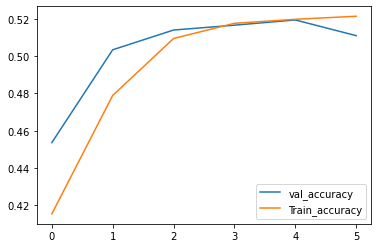

In [66]:
plt.plot(result['val_accuracy'],label='val_accuracy')
plt.plot(result['accuracy'],label='Train_accuracy')
plt.legend()
plt.show()

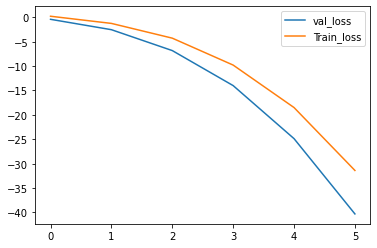

In [67]:
plt.plot(result['val_loss'],label='val_loss')
plt.plot(result['loss'],label='Train_loss')
plt.legend()
plt.show()

In [68]:
model.evaluate(X_val,y_val)

5000/5000 [==============================] - 0s 58us/step


[-40.29834183807373, 0.5109999775886536]

# Test Time

In [69]:
test=pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

In [70]:
test.shape

(3534, 3)

In [71]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [72]:
test['selected_text']=test['text'].apply(cleanTxt)

In [73]:
test.head()

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!,positive,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,http://twitpic.com/4w75p - I like it!!


In [74]:
X_test=test['selected_text']

In [75]:
X_test.shape

(3534,)

In [76]:
X_test=count_vec.transform(X_test)

In [77]:
X_test.shape

(3534, 17338)

In [78]:
X_test=tfidf.transform(X_test)

In [79]:
print(X_test[0])

  (0, 15811)	0.48613992582791005
  (0, 13438)	0.6051281090804466
  (0, 7757)	0.3810279819505397
  (0, 4475)	0.303547490792459
  (0, 3746)	0.4002056245495039


In [80]:
y_pred=model.predict(X_test)

In [81]:
# y_pred[y_pred>0.5]=1

In [82]:
# y_pred=y_pred.astype('int')

In [83]:
y_pred.shape

(3534, 1)

In [84]:
ids=test['textID']
ids.shape

(3534,)

In [85]:
my_submission = pd.DataFrame({'textID': test.textID.values, 'selected_text': test.selected_text})
my_submission



,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!
...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ..."
3530,416863ce47,All alone in this old house again. Thanks for...
3531,6332da480c,I know what you mean. My little dog is sinkin...
3532,df1baec676,_sutra what is your next youtube video gonna b...


In [86]:
import csv
my_submission.to_csv('submission.csv', index=False)